In [6]:
import os
nthreads = 10
os.environ["OMP_NUM_THREADS"] = str(nthreads) 
os.environ["OPENBLAS_NUM_THREADS"] = str(nthreads) 
os.environ["MKL_NUM_THREADS"] = str(nthreads)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
from mne import events_from_annotations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from utils.utils import *
from utils.entropy import excess_entropy_rate

from pycrostates.cluster import ModKMeans
from pycrostates.preprocessing import extract_gfp_peaks
from pycrostates.io import ChData, read_cluster
from pycrostates.preprocessing import resample
#from pycrostates.segmentation import excess_entropy_rate

from pycrostates.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    dunn_score,
    davies_bouldin_score,
)

from mne.io import RawArray
from mne import Annotations

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
### Load infos
info = load_info()
n_subj = 44
subjects = np.arange(n_subj) + 1

Reading /data/barzon/stroop/ss01_clean.fdt
Reading 0 ... 2439999  =      0.000 ...  4879.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.3s finished


In [5]:
### Load dataset
raw = load_dataset(1)

### Load events id
events, events_id = events_from_annotations(raw)
tasks = list(events_id.keys())[1:7]
tasks = ['REST']+tasks
print(tasks)

Reading /data/barzon/stroop/ss01_clean.fdt
Reading 0 ... 2439999  =      0.000 ...  4879.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']
['REST', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.2s finished


# Clustering - single subject

In [10]:
folder_to_save = 'results_pycrostates_250_Hz/'
#folder_to_save = 'results_pycrostates/'
scores_names = ['subj', 'K', 'GEV', 'silhouette', 'calinski-harabasz', 'dunn', 'davies_bouldin']

In [11]:
### Define global params
cluster_range = np.arange(2,11)
min_peak_distance = 10
max_peaks = int(1e4)

### Useful params
n_jobs = 10
to_save = True

### Example with resampling

In [39]:
n_cluster = 7
subject_id = 1

# load Data
print('Loading dataset...')
raw = load_dataset(subject_id)

# extract GFP peaks
print('Extracting GFP peaks...')
gfp_peaks = extract_gfp_peaks(raw, min_peak_distance=min_peak_distance)

# do resampling
print('Resampling')
resamples = resample(raw, n_resamples=3, n_samples=max_peaks, random_state=42)

resample_results = []
for k, resamp in enumerate(resamples):
    print('k=', k)
    # fit Modified K-means
    ModK = ModKMeans(n_clusters=n_cluster, random_state=42)
    ModK.fit(resamp, n_jobs=n_jobs, verbose="WARNING")
    resample_results.append(ModK)

Loading dataset...
Extracting GFP peaks...
Resampling
k= 0
k= 1
k= 2


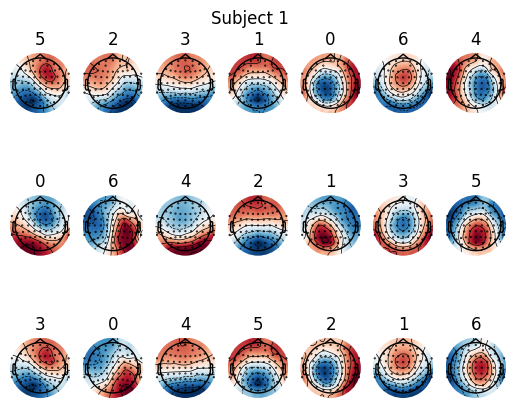

In [48]:
# reorder
orders = [[5,2,3,1,0,6,4],
          [0,6,4,2,1,3,5],
          [3,0,4,5,2,1,6]
         ]

reordered = [resample_results[k].copy() for k in range(len(orders))]
[reordered[k].reorder_clusters(order=orders[k]) for k in range(len(orders)) if orders[k] is not None]

f, ax = plt.subplots(nrows=len(resamples), ncols=n_cluster)

for k, resamp in enumerate(resamples):
    fig = reordered[k].plot(axes=ax[k, :], show=False)
#plt.subplots_adjust(top=0.9, hspace=0.5)
plt.suptitle('Subject '+str(subject_id))
plt.show()

In [9]:
### Init array to store
individual_cluster_centers = [ [] for _ in cluster_range]

scores = []
models = []

### Loop over subjects
for subject_id in subjects: #[:total_subj]:
    print(f'----- SUBJECT {subject_id} -----')
    
    # load Data
    print('Loading dataset...')
    raw = load_dataset(subject_id)
        
    # extract GFP peaks
    print('Extracting GFP peaks...')
    gfp_peaks = extract_gfp_peaks(raw, min_peak_distance=min_peak_distance)
    
    # divide in each conditions (create mask...)
    
    if max_peaks is not None:
        ### Randomly crop gfp_peaks to speedup computations
        n_peaks = gfp_peaks.get_data().shape[1]
        print(f'Total peaks: {n_peaks}')
        if max_peaks>n_peaks:
            continue
        print(f'Randomly selecting {max_peaks} peaks...')
        index_to_retain = np.random.choice(np.arange(n_peaks), max_peaks, replace=False)
        gfp_peaks = ChData( gfp_peaks.get_data()[:,index_to_retain], gfp_peaks.info )
    
    ### subject level clustering
    print('Perform clustering...')
    tmp_scores = np.zeros((len(cluster_range),len(scores_names)))
    
    for idx_clust, n_clusters in enumerate(cluster_range):
        print(f'[*] K={n_clusters}')
        
        ModK = ModKMeans(n_clusters=n_clusters)
        ModK.fit(gfp_peaks, n_jobs=n_jobs)
        
        # Store clustering results
        models.append(ModK)
        individual_cluster_centers[idx_clust].append(ModK.cluster_centers_)
        
        # Save centroids
        if to_save:
            np.save(folder_to_save+f'maps_subj_{subject_id}_k_{n_clusters}.npy', ModK.cluster_centers_)
        
        # compute scores
        print('     Compute scores...')
        tmp_scores[idx_clust] = [subject_id, n_clusters,ModK.GEV_, silhouette_score(ModK),
                                 calinski_harabasz_score(ModK), dunn_score(ModK), davies_bouldin_score(ModK)]
        
    scores.append(tmp_scores)

### Create dataframe
df = pd.DataFrame(np.vstack(scores), columns=scores_names)
df['subj'] = df['subj'].values.astype(int)
df['K'] = df['K'].values.astype(int)

df.to_csv(folder_to_save+'scores.csv')

----- SUBJECT 1 -----
Loading dataset...
Reading /data/barzon/stroop/ss01_clean.fdt
Reading 0 ... 2439999  =      0.000 ...  4879.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.0s finished


Extracting GFP peaks...
Total peaks: 82320
Randomly selecting 10000 peaks...
Perform clustering...
[*] K=2
     Compute scores...
[*] K=3
     Compute scores...
[*] K=4
     Compute scores...
[*] K=5
     Compute scores...
[*] K=6
     Compute scores...
[*] K=7
     Compute scores...
[*] K=8
     Compute scores...
[*] K=9
     Compute scores...
[*] K=10
     Compute scores...
----- SUBJECT 2 -----
Loading dataset...
Extracting GFP peaks...
Total peaks: 72920
Randomly selecting 10000 peaks...
Perform clustering...
[*] K=2
     Compute scores...
[*] K=3
     Compute scores...
[*] K=4
     Compute scores...
[*] K=5
     Compute scores...
[*] K=6
     Compute scores...
[*] K=7
     Compute scores...
[*] K=8
     Compute scores...
[*] K=9
     Compute scores...
[*] K=10
     Compute scores...
----- SUBJECT 3 -----
Loading dataset...
Extracting GFP peaks...
Total peaks: 80006
Randomly selecting 10000 peaks...
Perform clustering...
[*] K=2
     Compute scores...
[*] K=3
     Compute scores...

[*] K=6
     Compute scores...
[*] K=7
     Compute scores...
[*] K=8
     Compute scores...
[*] K=9
     Compute scores...
[*] K=10
     Compute scores...
----- SUBJECT 21 -----
Loading dataset...
Extracting GFP peaks...
Total peaks: 79436
Randomly selecting 10000 peaks...
Perform clustering...
[*] K=2
     Compute scores...
[*] K=3
     Compute scores...
[*] K=4
     Compute scores...
[*] K=5
     Compute scores...
[*] K=6
     Compute scores...
[*] K=7
     Compute scores...
[*] K=8
     Compute scores...
[*] K=9
     Compute scores...
[*] K=10
     Compute scores...
----- SUBJECT 22 -----
Loading dataset...
Extracting GFP peaks...
Total peaks: 94228
Randomly selecting 10000 peaks...
Perform clustering...
[*] K=2
     Compute scores...
[*] K=3
     Compute scores...
[*] K=4
     Compute scores...
[*] K=5
     Compute scores...
[*] K=6
     Compute scores...
[*] K=7
     Compute scores...
[*] K=8
     Compute scores...
[*] K=9
     Compute scores...
[*] K=10
     Compute scores...
--

Extracting GFP peaks...
Total peaks: 76018
Randomly selecting 10000 peaks...
Perform clustering...
[*] K=2
     Compute scores...
[*] K=3
     Compute scores...
[*] K=4
     Compute scores...
[*] K=5
     Compute scores...
[*] K=6
     Compute scores...
[*] K=7
     Compute scores...
[*] K=8
     Compute scores...
[*] K=9
     Compute scores...
[*] K=10
     Compute scores...
----- SUBJECT 41 -----
Loading dataset...
Extracting GFP peaks...
Total peaks: 78461
Randomly selecting 10000 peaks...
Perform clustering...
[*] K=2
     Compute scores...
[*] K=3
     Compute scores...
[*] K=4
     Compute scores...
[*] K=5
     Compute scores...
[*] K=6
     Compute scores...
[*] K=7
     Compute scores...
[*] K=8
     Compute scores...
[*] K=9
     Compute scores...
[*] K=10
     Compute scores...
----- SUBJECT 42 -----
Loading dataset...
Extracting GFP peaks...
Total peaks: 86471
Randomly selecting 10000 peaks...
Perform clustering...
[*] K=2
     Compute scores...
[*] K=3
     Compute scores.

# Clustering - group level

In [12]:
group_maps = []
models = []

for n_clusters in cluster_range:
    print(f'[*] K={n_clusters}')
    data_to_cluster = []
    
    ### Load single subject maps
    for subject_id in subjects:
        tmp_maps = np.load(folder_to_save+f'maps_subj_{subject_id}_k_{n_clusters}.npy')
        data_to_cluster.append(tmp_maps)
        
    data_to_cluster = np.vstack(data_to_cluster)
    print('data shape:', data_to_cluster.shape)
    data_to_cluster = ChData( data_to_cluster.T, gfp_peaks.info )
    
    ### Perform clustering
    ModK = ModKMeans(n_clusters=n_clusters)
    ModK.fit(data_to_cluster, n_jobs=n_jobs)
        
    # Store clustering results
    group_maps.append(ModK.cluster_centers_)
    models.append(ModK)
    
    # Save centroids
    np.save(folder_to_save+f'maps_group_k_{n_clusters}.npy', ModK.cluster_centers_)
    ModK.save(folder_to_save+f'clustering_group_k_{n_clusters}.fif')

[*] K=2
data shape: (88, 64)
[*] K=3
data shape: (132, 64)
[*] K=4
data shape: (176, 64)
[*] K=5
data shape: (220, 64)
[*] K=6
data shape: (264, 64)
[*] K=7
data shape: (308, 64)
[*] K=8
data shape: (352, 64)
[*] K=9
data shape: (396, 64)
[*] K=10
data shape: (440, 64)


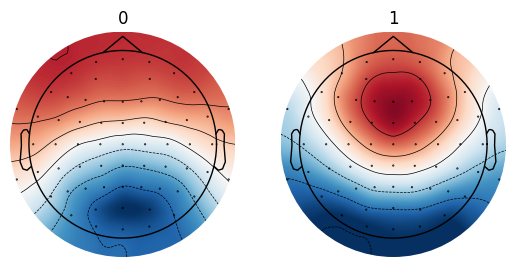

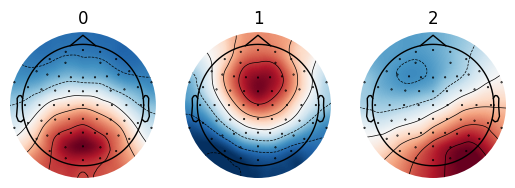

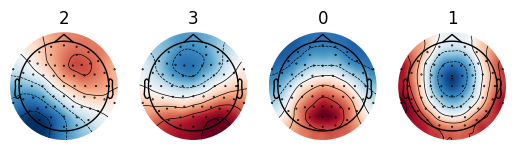

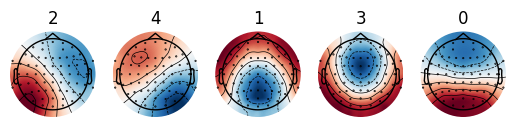

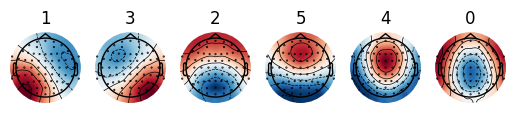

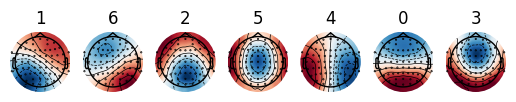

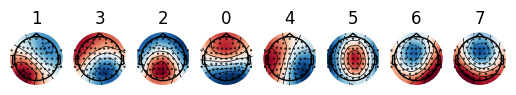

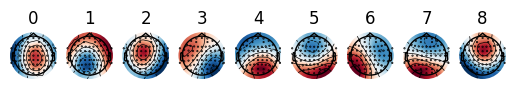

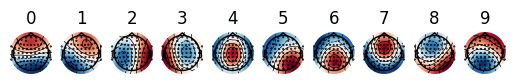

In [17]:
for tmp_mod in models:
    tmp_mod.plot()
    plt.show()

# Backfitting

In [8]:
def convert_params_stat_to_df(microstate_params):
    df = pd.DataFrame(columns=['microstate', 'mean_corr', 'gev', 'timecov', 'meandurs', 'occurrences'])

    # Iterate over the dictionary and populate the DataFrame
    for key, value in microstate_params.items():
        if key=='unlabeled':
            continue
        microstate_name, parameter_name = key.split('_', 1)
        if microstate_name not in df['microstate'].unique():
            df = df.append({'microstate': microstate_name}, ignore_index=True)
        df.loc[df['microstate'] == microstate_name, parameter_name] = value
        
    return df

def count_trans(series, n_states, lag):
    '''
    Compute co-occurrence matrix
    '''
    q_matrix = np.zeros((n_states,n_states))
    
    for i in range(n_states):
        # init state
        s_in = series[:-lag] == i
    
        for j in range(n_states):
            # ending state
            s_out = series[lag:] == j
            # count occurrences
            q_matrix[i,j] = np.sum(s_in*s_out)
    
    return q_matrix

def create_task_annotations(task, events, events_id, tmax):    
    if task == 'REST':
        '''
        my_annot = Annotations(
            onset=[events[0,0]/info['sfreq']],  # in seconds
            duration=[(tmax-events[0,0])/info['sfreq']],  # in seconds, too
            description=["bad"],
        )
        '''
        
        ### create chunks of almost 2 seconds for consistency
        rest_end = events[0,0]/info['sfreq']
        total_end = (tmax-events[0,0])/info['sfreq']
        
        t_chk = 2. # seconds
        delta_chk = 1.
        n_chk = int(rest_end // t_chk)
        
        onset = np.arange(1,n_chk+1) * t_chk
        onset += np.arange(n_chk) * delta_chk
        duration = [delta_chk] * n_chk
        
        ### add last events
        onset = np.concatenate([onset, [rest_end]])
        duration = np.concatenate([duration, [total_end]])
        
        my_annot = Annotations(
            onset=onset,  # in seconds
            duration=duration,  # in seconds, too
            description=["bad"],
        )
    else:
        ### task
        tmp_id = events_id[task]

        # get task event
        idx_event_task = np.where(events[:,2]==tmp_id)[0]

        # onset is the event preceding each task event
        onset = events[idx_event_task+1][:,0]
        # add first event as initial timestep
        onset = np.concatenate([[0], onset])

        # finish is the start of the task
        finish = events[idx_event_task][:,0]
        # add last event as final timestep
        finish = np.concatenate([finish, [tmax]])

        duration = finish - onset

        # convert to seconds
        onset = onset / info['sfreq']
        duration = duration / info['sfreq']
        
        my_annot = Annotations(
            onset=onset,  # in seconds
            duration=duration,  # in seconds, too
            description=["bad"]*len(onset),
        )
        
    return my_annot

In [77]:
create_task_annotations('REST', events, events_id, T)

<Annotations | 136 segments: bad (136)>

Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


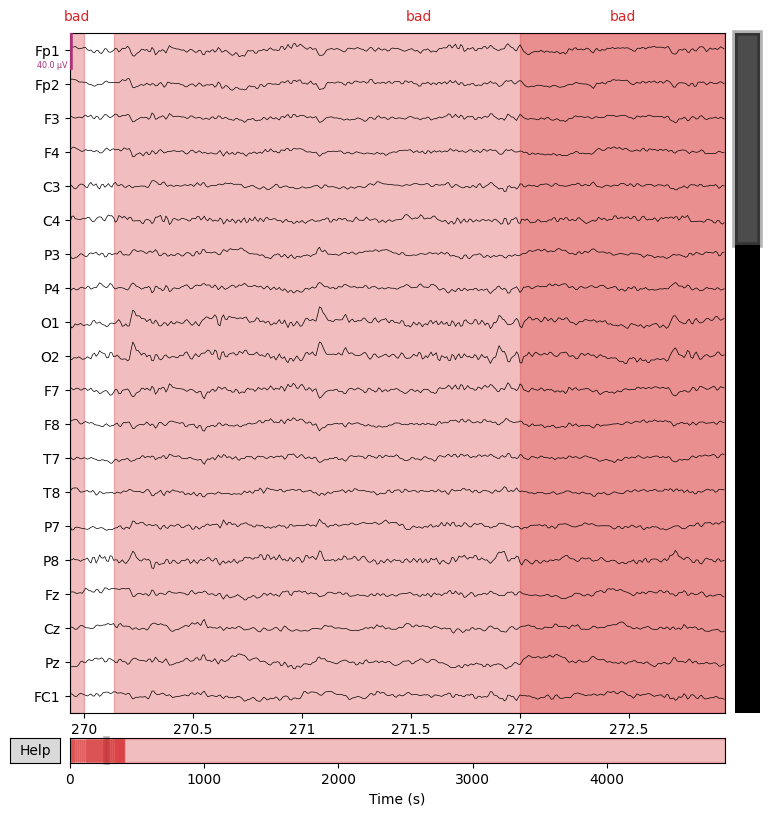

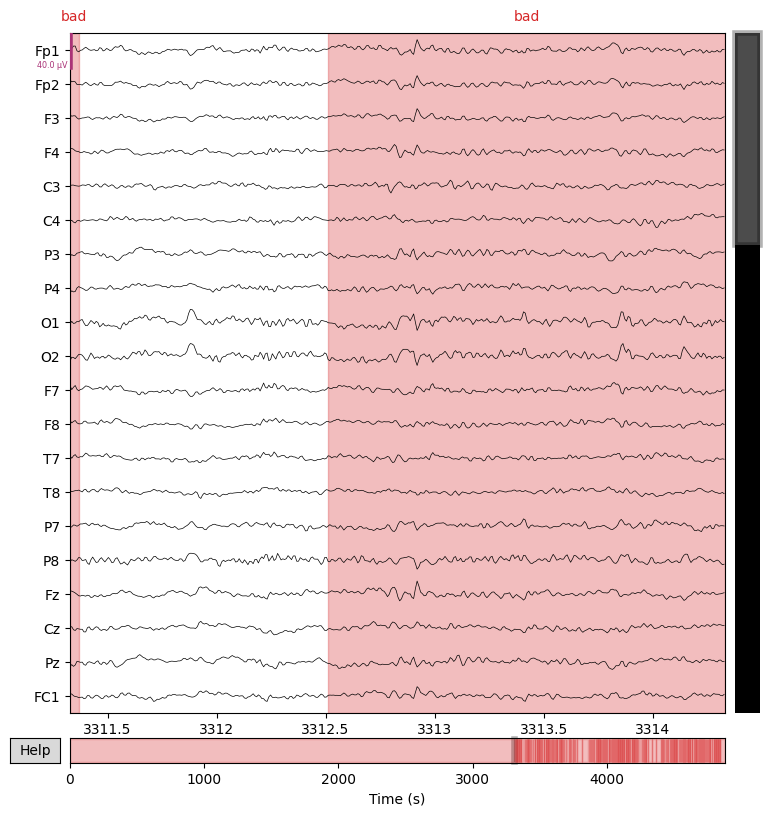

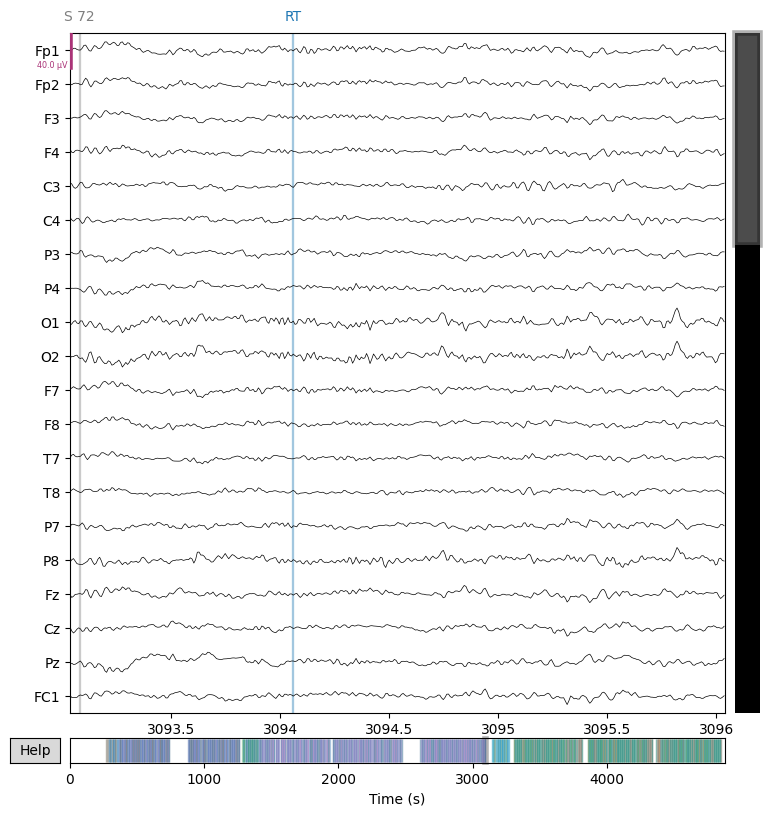

In [80]:
### Example
fs = info['sfreq']
prova = raw.copy()
T = prova.get_data().shape[1]
events, events_id = events_from_annotations(prova)

# resting
my_annot = create_task_annotations('REST', events, events_id, T)

resting = prova.copy().set_annotations(my_annot)

resting.plot(start=events[0,0] / fs - 50/fs, duration=3)
plt.show()

# task
my_annot = create_task_annotations('S 22', events, events_id, T)

task = prova.copy().set_annotations(my_annot)

task.plot(start=events[events[:,2]==events_id[tasks[2]]][0,0] / fs - 10/fs, duration=3)
plt.show()

prova.plot(start=events[events[:,2]==events_id[tasks[-1]]][-1,0] / fs - 10/fs, duration=3)
plt.show()

In [49]:
reject_edges = True

factor = 0
half_window_size = 0
min_segment_length = 0

folder_statistics = folder_to_save + f'rest_chunked_statistics_factor_{factor}_window_{half_window_size}_segment_{min_segment_length}/'
os.makedirs(folder_statistics, exist_ok=True)

print(folder_statistics)

results_pycrostates_250_Hz/rest_chunked_statistics_factor_0_window_0_segment_0/


In [ ]:
### Data to store
results = []
stats_all = [[] for _ in cluster_range]
tmats_all = [[] for _ in cluster_range]
exc_ent_all = [[] for _ in cluster_range]

### Load group clustering
print('Loading stored group clustering...\n')
models = [read_cluster(folder_to_save+f'clustering_group_k_{n_clusters}.fif') for n_clusters in cluster_range]

### Loop over subjects
for subject_id in subjects:
    print(f'----- SUBJECT {subject_id}/{n_subj} -----')
    
    # load data
    print('Loading dataset...')
    raw = load_dataset(subject_id)
    tmax = raw.n_times
    
    # get events
    events, events_id = events_from_annotations(raw)
    
    ### Loop over conditions
    for idx_task, task in enumerate(tasks):
        print(f'[*] {task}')
        
        # get annotations
        my_annot = create_task_annotations(task, events, events_id, tmax)
        
        # create temporary dataset w task annotations
        task_data = raw.copy().set_annotations(my_annot)

        ### Loop over clusters
        for idx_clust, n_clusters in enumerate(cluster_range):
            #print(f'    [*] K={n_clusters}')
            
            # perform backfitting
            segmentation = models[idx_clust].predict(task_data, factor=factor, half_window_size=half_window_size,
                                                    min_segment_length=min_segment_length, reject_edges=reject_edges)
            
            # compute statistics
            stats = segmentation.compute_parameters(norm_gfp=False)
            #tmat = segmentation.compute_transition_matrix(ignore_self=False)
            tmat = count_trans(segmentation.labels, n_clusters, lag=1)
            
            # compute entropy rate
            ent_rate, _, _, _, _ = excess_entropy_rate(segmentation.labels, history_length, n_jobs=history_length)
            exc_ent_all[idx_clust].append(ent_rate)
            
            # covert statistics to dataframe
            df_stats = convert_params_stat_to_df(stats)
            # add column w subject id
            df_stats.insert(0, 'subject', subject_id)
            # add column w task id
            df_stats.insert(1, 'task', task)
            
            # store
            stats_all[idx_clust].append(df_stats)
            tmats_all[idx_clust].append(tmat)
            
### Concatenate results
stats_all = [pd.concat(tmp) for tmp in stats_all]
tmats_all = [np.stack(tmp) for tmp in tmats_all]

### Store results
[stats_all[idx_clust].to_csv(folder_statistics+f'stats_k_{n_clusters}.csv', index=False) for idx_clust, n_clusters in enumerate(cluster_range)]
[np.save(folder_statistics+f'tmats_k_{n_clusters}.npy', tmats_all[idx_clust]) for idx_clust, n_clusters in enumerate(cluster_range)]

tmp_subjs = np.repeat(subjects, len(tasks))
tmp_tasks = np.tile(tasks, n_subj)

[pd.DataFrame(np.array([tmp_subjs,tmp_tasks,exc_ent_all[idx_clust]]).T, columns=['subject','task','ent_rate']).to_csv(folder_statistics+f'ent_rate_k_{n_clusters}.csv', index=False)
 for idx_clust, n_clusters in enumerate(cluster_range)]

Loading stored group clustering...

----- SUBJECT 1/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss01_clean.fdt
Reading 0 ... 2439999  =      0.000 ...  4879.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.1s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 2/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss02_clean.fdt
Reading 0 ... 2213499  =      0.000 ...  4426.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.8s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 3/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss03_clean.fdt
Reading 0 ... 2382499  =      0.000 ...  4764.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.9s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 4/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss04_clean.fdt
Reading 0 ... 2183499  =      0.000 ...  4366.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.8s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 5/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss05_clean.fdt
Reading 0 ... 2542999  =      0.000 ...  5085.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.1s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 6/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss06_clean.fdt
Reading 0 ... 2436499  =      0.000 ...  4872.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.0s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 7/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss07_clean.fdt
Reading 0 ... 2352499  =      0.000 ...  4704.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.9s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 8/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss08_clean.fdt
Reading 0 ... 2299499  =      0.000 ...  4598.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.9s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 9/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss09_clean.fdt
Reading 0 ... 2395499  =      0.000 ...  4790.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.0s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 10/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss10_clean.fdt
Reading 0 ... 2300499  =      0.000 ...  4600.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.9s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 11/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss11_clean.fdt
Reading 0 ... 2260499  =      0.000 ...  4520.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.8s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 12/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss12_clean.fdt
Reading 0 ... 2545499  =      0.000 ...  5090.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.1s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 13/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss13_clean.fdt
Reading 0 ... 2208999  =      0.000 ...  4417.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.9s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 14/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss14_clean.fdt
Reading 0 ... 2342499  =      0.000 ...  4684.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.9s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 15/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss15_clean.fdt
Reading 0 ... 2199499  =      0.000 ...  4398.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.8s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 16/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss16_clean.fdt
Reading 0 ... 2402999  =      0.000 ...  4805.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.0s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 17/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss17_clean.fdt
Reading 0 ... 2387999  =      0.000 ...  4775.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.0s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 18/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss18_clean.fdt
Reading 0 ... 2327999  =      0.000 ...  4655.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.9s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 19/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss19_clean.fdt
Reading 0 ... 2774999  =      0.000 ...  5549.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.3s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 20/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss20_clean.fdt
Reading 0 ... 2296999  =      0.000 ...  4593.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.9s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 21/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss21_clean.fdt
Reading 0 ... 2389999  =      0.000 ...  4779.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.0s finished


[*] REST


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 21


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 22


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 51


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 52


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 71


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

[*] S 72


  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

  0%|          |  : 0/9 [00:00<?,       ?it/s]

----- SUBJECT 22/44 -----
Loading dataset...
Reading /data/barzon/stroop/ss22_clean.fdt
Reading 0 ... 2827499  =      0.000 ...  5654.998 secs...
Filtering raw data in 1 contiguous segment
